Hola Julio!

Mi nombre es Miguel Gutierrez y revisare tu proyecto ! Para darte un contexto, trabajo como cientifico de datos en Mercado Libre. Asi que seras revisado por alguien que aplica a diario todo este tipo de tecnicas en su vida laboral ! Espero una vez finalizes este bootcamp, tambien lo apliques ! Buena suerte !

Cuando vea un error la primera vez, lo señalare. Dejare que encuentres la solucion. Tambien en el texto hare algunas observaciones de como podrias mejorar el codio y tambien hare comentarios de tus percepciones sobre el tema. Si no pueds manejar la tarea, te dare una pista precisa en la siguiente iteraciones y algunos ejemplos practicos. Estare abierto a cualquierda duda y discusion respecto al tema. En general los comentarios de advertencia tu decides si tomarlos o no. No es necesario que acates todos los cambios de advertencia.

Encontraras mis comentarios en el siguiente formato - *Por favor no mueves, modifiques o elimines los comentarios*.

Podras encontrar mis comentarios en verde, amarillo o rojo como estos:


<div class="alert alert-block alert-success">
<b>Comentario revisor</b> <a class="tocSkip"></a>

Excelente. Todo esta perfecto.
</div>

<div class="alert alert-block alert-warning">
<b>Comentario revisor</b> <a class="tocSkip"></a>

Comentarios. Algunas recomendaciones.
</div>

<div class="alert alert-block alert-danger">

<b>Comentario revisor</b> <a class="tocSkip"></a>

Necesita ser arreglado. El bloque requiere algunas correciones. El trabajo no podra ser acceptado si tiene comentarios en rojo.
</div>

Puedes responderme utilizando este tipo de comentario:

<div class="alert alert-block alert-info">
<b>Respuesta estudiante.</b> <a class="tocSkip"></a>
</div>

# Descripción del proyecto

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Construye un modelo para dicha predicción.

La métrica RECM en el conjunto de prueba no debe ser superior a 48.

## Instrucciones del proyecto.

In [1]:
#Importamos librerias relevantes
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import zscore
from scipy.stats import mstats
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import r2_score
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error

import sklearn.preprocessing
from catboost import CatBoostRegressor
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.impute import KNNImputer
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LinearRegression

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split, GridSearchCV

1. Descarga los datos y haz el remuestreo por una hora.

In [2]:
data = pd.read_csv('/datasets/taxi.csv', index_col = [0], parse_dates = [0])

data.sort_index(inplace=True)
data = data.resample('1h').sum()
data

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


## Preparación y Analisis

In [3]:
data.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


In [5]:
data.duplicated().sum()

4165

In [6]:
duplicates = data[data.duplicated(subset=['num_orders'], keep=False)]
duplicates

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


<div class="alert alert-block alert-warning">

<b>Comentario revisor</b> <a class="tocSkip"></a>

No esta bien eliminar duplicados por numero de ordenes, puedes tener el mismo numero de ordenes y es valido. Tal vez lo que is estaria bien es eliminar duplicados del subset (datetime,num_orders)</div>


In [7]:
data.isna().sum()

num_orders    0
dtype: int64

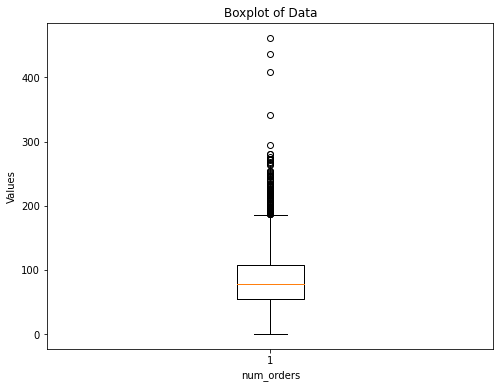

In [8]:
#Creamos un diagrama de caja y bigotes
plt.figure(figsize=(8, 6))  #Ajustamos la figura
plt.boxplot(data.values) 

#Ponemos el titulo y etiquetas
plt.title('Boxplot of Data')
plt.xlabel('num_orders')
plt.ylabel('Values')

#Mostramos
plt.show()

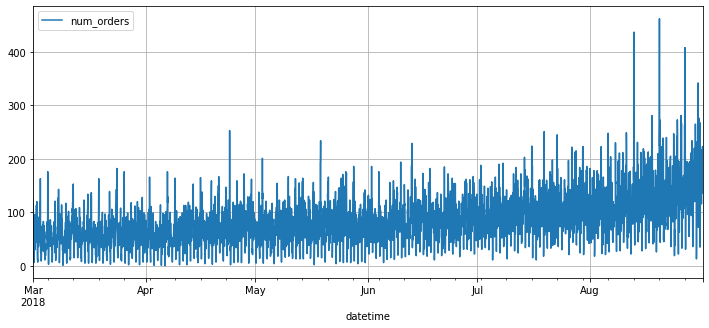

In [9]:
data.plot(figsize=(12,5), grid=True)
plt.show()

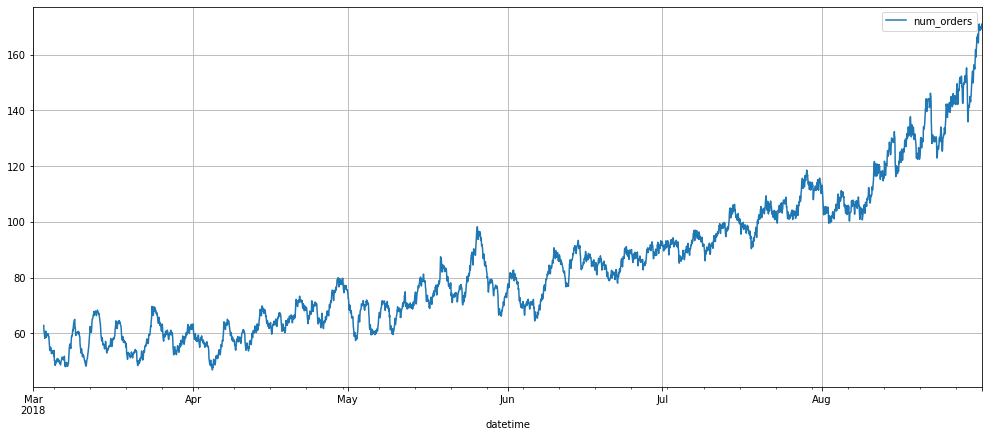

In [10]:
data.rolling(50).mean().plot(figsize=(17,7), grid=True)
plt.show()

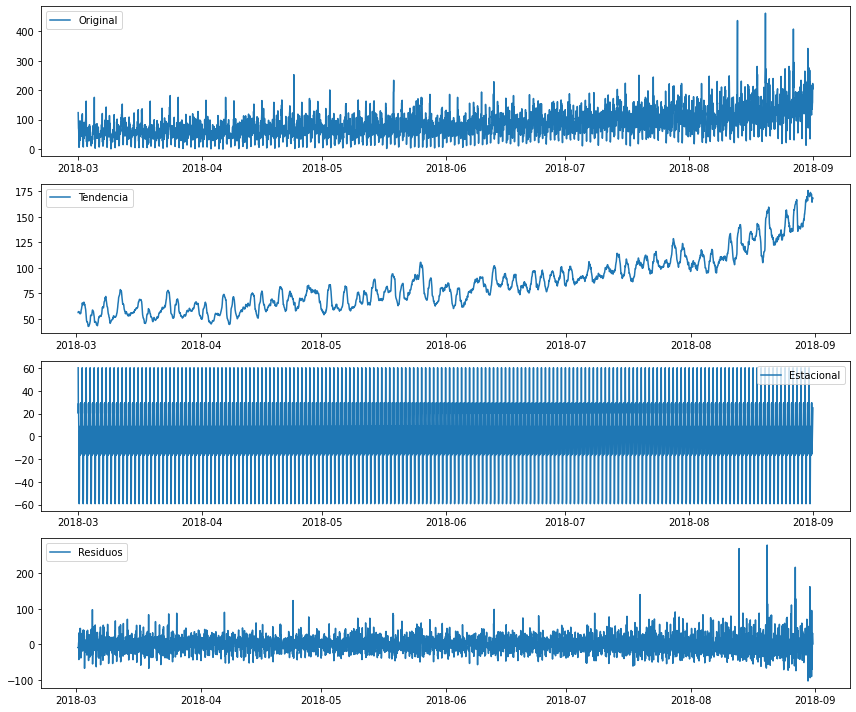

In [11]:
# Perform seasonal decomposition
seasonal = seasonal_decompose(data['num_orders'], model='additive')

# Plot the decomposition results
fig, ax = plt.subplots(4, figsize=(12, 10))
ax[0].plot(data.index, data['num_orders'], label='Original')
ax[0].legend()
ax[1].plot(data.index, seasonal.trend, label='Tendencia')
ax[1].legend()
ax[2].plot(data.index, seasonal.seasonal, label='Estacional')
ax[2].legend()
ax[3].plot(data.index, seasonal.resid, label='Residuos')
ax[3].legend()

plt.tight_layout()
plt.show()

In [12]:
#Preparamos los datos para los modelos
def make_features(data, max_lag, rolling_mean_size):
    data['hour'] = data.index.hour
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag{}'.format(lag)] = data['num_orders'].shift(lag)
        
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data

In [13]:
data_features = make_features(data, 4, 6)

data_features.head(10)

,num_orders,hour,month,day,dayofweek,lag1,lag2,lag3,lag4,rolling_mean
datetime,,,,,,,,,,
2018-03-01 00:00:00,124,0,3,1,3,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,1,3,124.0,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2,3,1,3,85.0,124.0,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,1,3,71.0,85.0,124.0,NaN,NaN
2018-03-01 04:00:00,43,4,3,1,3,66.0,71.0,85.0,124.0,NaN
2018-03-01 05:00:00,6,5,3,1,3,43.0,66.0,71.0,85.0,NaN
2018-03-01 06:00:00,12,6,3,1,3,6.0,43.0,66.0,71.0,65.833333
2018-03-01 07:00:00,15,7,3,1,3,12.0,6.0,43.0,66.0,47.166667
2018-03-01 08:00:00,34,8,3,1,3,15.0,12.0,6.0,43.0,35.500000


In [14]:
data_features = data_features.dropna()
data_features.isna().sum().sum()

0

Hicimos una variable que guarda los datos de numeros de orden con el indice de fecha y hora, siguiendo un remuestro de Hora ('H'). Luego vimos y analizamos los datos mediante diferentes herramientas como diagramas de caja y diagramas lineales, que muestran las tendencias, estacionalidad y residuos. En estos vimos que no hay tanta varianza y son bastante similares los resultados. Luego hicimos una funcion que haga los features para los modelos de ML con los parametros de: data, max_lag, rolling_mean_size. Aplicamos esta funcion a nuestros datos y posteriormente eliminamos los valores ausentes que se generaron por el shift().

## Formación

Entrenamos diferentes modelos con diferentes hiperparámetros. La muestra de prueba debe ser el 10% del conjunto de datos inicial.

In [15]:
#Hacemos el set de prueba y el que usaremos para entrenamiento y validacion
data_2, test = train_test_split(data_features, shuffle=False, test_size=0.1)

#Separamos los datos de entrenamiento y validación
train, valid = train_test_split(data_2, test_size=0.25, random_state=12345)

#Creamos features y targets para el entrenamiento
features_train = train.drop('num_orders', axis=1)
targets_train = train['num_orders']

#Creamos features y targets para el testeo
features_test = test.drop('num_orders', axis=1)
targets_test = test['num_orders']

#Creamos features y targets para la validación
features_valid = valid.drop('num_orders', axis=1)
targets_valid = valid['num_orders']

#Creamos features y targets para el entrenamiento de la validación
features_data_2 = data_2.drop('num_orders', axis=1)
targets_data_2 = data_2['num_orders']

#Comprobamos el tamaño de los sets
print('Entrenamiento')
print(features_train.shape)
print(targets_train.shape)
print()
print('Validación')
print(features_valid.shape)
print(targets_valid.shape)
print()
print('Test')
print(features_test.shape)
print(targets_test.shape)

Entrenamiento
(2976, 9)
(2976,)

Validación
(993, 9)
(993,)

Test
(441, 9)
(441,)


### LinearRegression

In [16]:
#Entrenamos con la regresion lineal
lr = LinearRegression()
lr.fit(features_train, targets_train)
lr_pred = lr.predict(features_valid)

print('RECM: ')
print(mean_squared_error(targets_valid, lr_pred, squared=False))

RECM: 
29.545197821964223


### RandomForestRegressor

In [19]:
#Definir los hiperparámetros a probar
param_grid = {
    'max_depth': [2, 3, 4, 5, 6],
    'min_samples_leaf': [2, 3, 4, 5, 6]
}

#Creamos el modelo de Bosque Aleatorio
rf = RandomForestRegressor(random_state=12345)

# Crear el objeto GridSearchCV
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring=make_scorer(mean_squared_error, squared=False))

# Definir una función para realizar la búsqueda de hiperparámetros
grid_search_rf.fit(features_train, targets_train)

#Obtener los mejores hiperparámetros y el mejor score
best_params = grid_search_rf.best_params_
best_score = grid_search_rf.best_score_

#Imprimir los mejores hiperparámetros y el mejor score
print('Mejores hiperparámetros:', best_params)
print('Mejor RECM:', best_score)

Mejores hiperparámetros: {'max_depth': 2, 'min_samples_leaf': 2}
Mejor RECM: 30.924850710882282


In [20]:
#Entrenar el modelo con los mejores hiperparámetros
best_rf = RandomForestRegressor(**grid_search_rf.best_params_)
best_rf.fit(features_train, targets_train)

#Realizar predicciones utilizando el modelo entrenado
rf_pred = best_rf.predict(features_valid)

#Calcular el score final
score = mean_squared_error(targets_valid, rf_pred, squared=False)

print()
print('Mejor RECM:', score)


Mejor RECM: 29.184941163492503


In [21]:
#Creamos una variable para añadirla a la lista vacía
error_rf = mean_squared_error(targets_valid, rf_pred, squared=False)

### CatBoost

In [22]:
cat = CatBoostRegressor(iterations=200, silent=True)
cat.fit(features_train, targets_train, eval_set=(features_valid, targets_valid))
cat_pred = cat.predict(features_valid)
print('RECM:')
print(mean_squared_error(targets_valid, cat_pred, squared=False))

RECM:
20.85054725127233


In [23]:
#Creamos una variable para añadirla a la lista vacía
error_catboost = mean_squared_error(targets_valid, cat_pred, squared=False)

### LightGBM

In [24]:
lgbm = lgb.LGBMRegressor(random_state = 12345)
lgbm.fit(features_train, targets_train, eval_metric = 'RMSE', eval_set=(features_valid, targets_valid))
lgbm_pred = lgbm.predict(features_valid)
print('RECM:')
print(mean_squared_error(targets_valid, lgbm_pred, squared=False))

[1]	valid_0's rmse: 35.1257	valid_0's l2: 1233.81
[2]	valid_0's rmse: 33.1667	valid_0's l2: 1100.03
[3]	valid_0's rmse: 31.5283	valid_0's l2: 994.033
[4]	valid_0's rmse: 30.1235	valid_0's l2: 907.423
[5]	valid_0's rmse: 28.9064	valid_0's l2: 835.578
[6]	valid_0's rmse: 27.8619	valid_0's l2: 776.284
[7]	valid_0's rmse: 26.919	valid_0's l2: 724.632
[8]	valid_0's rmse: 26.1513	valid_0's l2: 683.893
[9]	valid_0's rmse: 25.5484	valid_0's l2: 652.722
[10]	valid_0's rmse: 25.0029	valid_0's l2: 625.143
[11]	valid_0's rmse: 24.5437	valid_0's l2: 602.393
[12]	valid_0's rmse: 24.1026	valid_0's l2: 580.938
[13]	valid_0's rmse: 23.7728	valid_0's l2: 565.148
[14]	valid_0's rmse: 23.4541	valid_0's l2: 550.095
[15]	valid_0's rmse: 23.0816	valid_0's l2: 532.762
[16]	valid_0's rmse: 22.8481	valid_0's l2: 522.034
[17]	valid_0's rmse: 22.5814	valid_0's l2: 509.92
[18]	valid_0's rmse: 22.3785	valid_0's l2: 500.796
[19]	valid_0's rmse: 22.2402	valid_0's l2: 494.625
[20]	valid_0's rmse: 21.9924	valid_0's l2:

In [25]:
#Creamos una variable para añadirla a la lista vacía
error_lightgbm = mean_squared_error(targets_valid, lgbm_pred, squared=False)

In [26]:
#Creamos un diccionario con los modelos y sus RMSE
rmse_dict = {
    'Model': ['Random Forest', 'CatBoost', 'LightGBM'],
    'RMSE': [error_rf, error_catboost, error_lightgbm]
}

#Creamos un Dataframe
rmse_df = pd.DataFrame(rmse_dict)
rmse_df

,Model,RMSE
0,Random Forest,29.184941
1,CatBoost,20.850547
2,LightGBM,20.723356


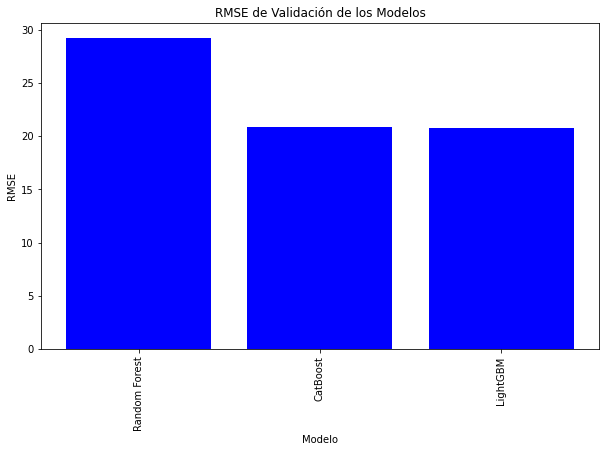

In [27]:
#Graficar el gráfico de barras para validación
plt.figure(figsize=(10, 6))
plt.bar(rmse_df['Model'], rmse_df['RMSE'], color='blue')
plt.xlabel('Modelo')
plt.ylabel('RMSE')
plt.title('RMSE de Validación de los Modelos')
plt.xticks(rotation=90)
plt.show()


Creamos los sets de entrenamiento, validacion y prueba, teniendo considerado que el de prueba tiene que ser del 10% del total de datos. Hemos probado 4 diferentes modelos, usando como umbral a la regresion lineal. De estos cuatro modelos podemos resaltar los mejores resultados siendo CatBoost y LightGBM, aunque, si quisieramos quedarnos con uno seria el modelo LightGBM, pues pasa el umbral requerido y es mejor que la regresion lineal en cuanto a RMSE.

## Prueba

Probamos los datos usando la muestra de prueba y proporcionamos una conclusión.

In [28]:
lgbm = lgb.LGBMRegressor(random_state=12345)
lgbm.fit(features_data_2, targets_data_2, eval_metric = 'RMSE', eval_set=(features_test, targets_test))
lgbm_pred = lgbm.predict(features_test)
print('RECM:')
print(mean_squared_error(targets_test, lgbm_pred, squared=False))

[1]	valid_0's rmse: 81.3799	valid_0's l2: 6622.68
[2]	valid_0's rmse: 78.131	valid_0's l2: 6104.45
[3]	valid_0's rmse: 75.2607	valid_0's l2: 5664.17
[4]	valid_0's rmse: 72.3328	valid_0's l2: 5232.04
[5]	valid_0's rmse: 70.0718	valid_0's l2: 4910.05
[6]	valid_0's rmse: 67.9618	valid_0's l2: 4618.81
[7]	valid_0's rmse: 66.2428	valid_0's l2: 4388.11
[8]	valid_0's rmse: 64.7606	valid_0's l2: 4193.93
[9]	valid_0's rmse: 63.0295	valid_0's l2: 3972.71
[10]	valid_0's rmse: 61.3768	valid_0's l2: 3767.11
[11]	valid_0's rmse: 60.3954	valid_0's l2: 3647.6
[12]	valid_0's rmse: 59.2231	valid_0's l2: 3507.38
[13]	valid_0's rmse: 58.3974	valid_0's l2: 3410.25
[14]	valid_0's rmse: 57.5051	valid_0's l2: 3306.84
[15]	valid_0's rmse: 56.771	valid_0's l2: 3222.95
[16]	valid_0's rmse: 55.7254	valid_0's l2: 3105.32
[17]	valid_0's rmse: 54.9269	valid_0's l2: 3016.96
[18]	valid_0's rmse: 54.3335	valid_0's l2: 2952.13
[19]	valid_0's rmse: 53.3507	valid_0's l2: 2846.3
[20]	valid_0's rmse: 53.0217	valid_0's l2: 2

Vemos que el modelo LightBGM paso la prueba y umbral de cordura con un puntaje de 43.96, por lo que damos por concluido que la prueba fue exitosa.

# Conclusion

Hemos realizado un análisis de datos utilizando diferentes herramientas, como diagramas de caja y diagramas lineales, sobre una variable que contiene números de orden con índices de fecha y hora. Tras aplicar un remuestreo por hora ('H'), hemos observado que los datos no presentan una variabilidad significativa y muestran resultados bastante similares en términos de tendencias, estacionalidad y residuos.

A continuación, hemos desarrollado una función para generar características (features) utilizadas en modelos de aprendizaje automático, considerando los parámetros de datos, máximo desfase (max_lag) y tamaño de media móvil (rolling_mean_size). Posteriormente, hemos aplicado esta función a nuestros datos y eliminado los valores ausentes generados por la función shift().

Hemos dividido nuestros datos en conjuntos de entrenamiento, validación y prueba, asignando al conjunto de prueba el 10% del total de datos. Luego, hemos probado cuatro modelos diferentes, utilizando la regresión lineal como umbral de referencia. Entre estos modelos, hemos observado que CatBoost y LightGBM han obtenido los mejores resultados, pero si tuviéramos que elegir uno, el modelo LightGBM sería la opción preferida. Este modelo supera el umbral requerido en términos de RMSE y ofrece un rendimiento superior al de la regresión lineal.

En conclusión, el modelo LightGBM ha pasado la prueba y ha superado el umbral establecido, con un puntaje de 43.96. Por lo tanto, podemos afirmar que nuestra prueba ha sido exitosa y hemos encontrado un modelo satisfactorio para el análisis de los datos de números de orden.


<div class="alert alert-block alert-success">
<b>Comentario revisor</b> <a class="tocSkip"></a>

Veo todo perfecto, buenas conclusiones, hiciste le resample y creaste las variables correctamente.
</div>

# Lista de revisión

- [x]  	
Jupyter Notebook está abierto.
- [x]  El código no tiene errores
- [x]  Las celdas con el código han sido colocadas en el orden de ejecución.
- [x]  	
Los datos han sido descargados y preparados.
- [x]  Se ha realizado el paso 2: los datos han sido analizados
- [x]  Se entrenó el modelo y se seleccionaron los hiperparámetros
- [x]  Se han evaluado los modelos. Se expuso una conclusión
- [x] La *RECM* para el conjunto de prueba no es más de 48